# Oil Spill Classification
**Author:** Ipek Kochisarli
**Task:** Binary classification of oil spill presence  
**Goal:** Build a neural network model to detect oil spill presence from features and handle class imbalance  

This notebook demonstrates a full ML workflow:  
1. Load & inspect data  
2. Preprocess features & labels  
3. Handle imbalanced classes  
4. Build & train a neural network  
5. Evaluate model with multiple metrics  
6. Tune threshold for F1 score optimization  

In [1]:
# -------------------------------
# Import Libraries
# -------------------------------
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, average_precision_score, f1_score
)

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# -------------------------------
# Set random seeds for reproducibility
# -------------------------------
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)


In [2]:
# -------------------------------
# Load dataset
# -------------------------------
df = pd.read_csv('/Users/ipekkochisarli/Documents/Data/oil_spill_classification/data/oil_spill.csv')

# Quick inspection
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (937, 50)


,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_41,f_42,f_43,f_44,f_45,f_46,f_47,f_48,f_49,target
0,1,2558,1506.09,456.63,90,6395000,40.88,7.89,29780.0,0.19,...,2850.00,1000.00,763.16,135.46,3.73,0,33243.19,65.74,7.95,1
1,2,22325,79.11,841.03,180,55812500,51.11,1.21,61900.0,0.02,...,5750.00,11500.00,9593.48,1648.80,0.60,0,51572.04,65.73,6.26,0
2,3,115,1449.85,608.43,88,287500,40.42,7.34,3340.0,0.18,...,1400.00,250.00,150.00,45.13,9.33,1,31692.84,65.81,7.84,1
3,4,1201,1562.53,295.65,66,3002500,42.40,7.97,18030.0,0.19,...,6041.52,761.58,453.21,144.97,13.33,1,37696.21,65.67,8.07,1
4,5,312,950.27,440.86,37,780000,41.43,7.03,3350.0,0.17,...,1320.04,710.63,512.54,109.16,2.58,0,29038.17,65.66,7.35,0


In [3]:
# -------------------------------
# Check info and missing values
# -------------------------------
df.info()
print("\nMissing values:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 50 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f_1     937 non-null    int64  
 1   f_2     937 non-null    int64  
 2   f_3     937 non-null    float64
 3   f_4     937 non-null    float64
 4   f_5     937 non-null    int64  
 5   f_6     937 non-null    int64  
 6   f_7     937 non-null    float64
 7   f_8     937 non-null    float64
 8   f_9     937 non-null    float64
 9   f_10    937 non-null    float64
 10  f_11    937 non-null    float64
 11  f_12    937 non-null    float64
 12  f_13    937 non-null    float64
 13  f_14    937 non-null    float64
 14  f_15    937 non-null    float64
 15  f_16    937 non-null    float64
 16  f_17    937 non-null    float64
 17  f_18    937 non-null    float64
 18  f_19    937 non-null    float64
 19  f_20    937 non-null    float64
 20  f_21    937 non-null    float64
 21  f_22    937 non-null    float64
 22  f_

In [4]:
# Drop constant columns
if 'f_23' in df.columns:
    if df['f_23'].nunique() <= 1:
        df = df.drop('f_23', axis=1)
        print("Dropped 'f_23' as it is constant.")
    else:
        print("'f_23' has multiple values, keeping it.")


Dropped 'f_23' as it is constant.


Target class distribution:
 target
0    896
1     41
Name: count, dtype: int64


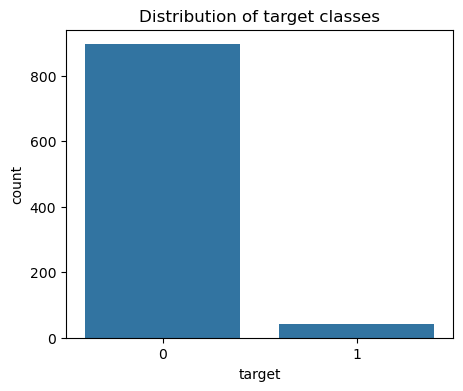

In [5]:
# Target class distribution
print("Target class distribution:\n", df['target'].value_counts())

plt.figure(figsize=(5,4))
sns.countplot(x='target', data=df)
plt.title("Distribution of target classes")
plt.show()


In [6]:
# Shuffle dataset
df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

# Features and target
X = df.drop('target', axis=1)
y = df['target'].astype(int)

print("Feature shape:", X.shape)
print("Label shape:", y.shape)


Feature shape: (937, 48)
Label shape: (937,)


In [7]:
# Stratified split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp
)

print("Shapes:")
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)

# Check class distribution
print("Train class distribution:", Counter(y_train))
print("Validation class distribution:", Counter(y_val))
print("Test class distribution:", Counter(y_test))


Shapes:
X_train: (655, 48)
X_val: (141, 48)
X_test: (141, 48)
Train class distribution: Counter({0: 626, 1: 29})
Validation class distribution: Counter({0: 135, 1: 6})
Test class distribution: Counter({0: 135, 1: 6})


In [8]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [9]:
# Handle class imbalance
classes = np.unique(y_train)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weights = {int(classes[i]): class_weights_array[i] for i in range(len(classes))}
print("Computed class weights:", class_weights)


Computed class weights: {0: 0.5231629392971247, 1: 11.293103448275861}


In [10]:
# Neural network architecture
n_features = X_train_scaled.shape[1]

inputs = Input(shape=(n_features,), name='input')
x = Dense(64, activation='relu', name='dense_1')(inputs)
x = BatchNormalization(name='bn_1')(x)
x = Dense(32, activation='relu', name='dense_2')(x)
x = Dropout(0.3, name='dropout_1')(x)
x = Dense(16, activation='relu', name='dense_3')(x)
outputs = Dense(1, activation='sigmoid', name='output')(x)

model = Model(inputs=inputs, outputs=outputs, name='OilSpillClassifier')
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "OilSpillClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,017 (23.50 KB)

 Trainable params: 5,889 (23.00 KB)

 Non-trainable params: 128 (512.00 B)

In [11]:
y_train_array = y_train.to_numpy()
y_val_array = y_val.to_numpy()
y_test_array = y_test.to_numpy()

early_stop = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=15,
    restore_best_weights=True,
    verbose=1
)


In [12]:
history = model.fit(
    X_train_scaled, y_train_array,
    validation_data=(X_val_scaled, y_val_array),
    epochs=200,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6605 - loss: 0.8541 - val_accuracy: 0.9291 - val_loss: 0.4868
Epoch 2/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7472 - loss: 0.6004 - val_accuracy: 0.9220 - val_loss: 0.4826
Epoch 3/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7898 - loss: 0.5299 - val_accuracy: 0.9007 - val_loss: 0.4592
Epoch 4/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7955 - loss: 0.4964 - val_accuracy: 0.8794 - val_loss: 0.4189
Epoch 5/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8211 - loss: 0.4087 - val_accuracy: 0.8582 - val_loss: 0.3635
Epoch 6/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8446 - loss: 0.3647 - val_accuracy: 0.8723 - val_loss: 0.3269
Epoch 7/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8400 - loss: 0.3164 - val_accuracy: 0.9220 - val_loss: 0.2850
Epoch 8/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8670 - loss: 0.3143 - val_accuracy: 0.9291 - v

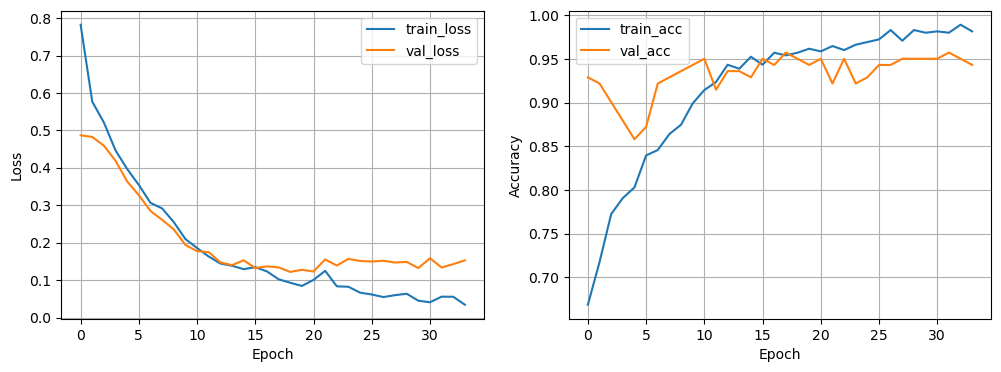

In [13]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()


In [14]:
y_test_prob = model.predict(X_test_scaled).ravel()
y_test_pred = (y_test_prob >= 0.5).astype(int)

# Metrics
test_loss, test_acc = model.evaluate(X_test_scaled, y_test_array, verbose=0)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

cm = confusion_matrix(y_test_array, y_test_pred)
print("\nConfusion Matrix:\n", cm)

print("\nClassification Report:")
print(classification_report(y_test_array, y_test_pred, digits=4))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Test loss: 0.1375, Test accuracy: 0.9433

Confusion Matrix:
 [[129   6]
 [  2   4]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9847    0.9556    0.9699       135
           1     0.4000    0.6667    0.5000         6

    accuracy                         0.9433       141
   macro avg     0.6924    0.8111    0.7350       141
weighted avg     0.9599    0.9433    0.9499       141



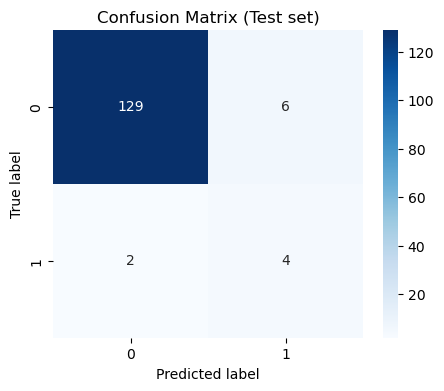

In [15]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Test set)')
plt.show()


ROC AUC: 0.9580, Average Precision (AP): 0.5428


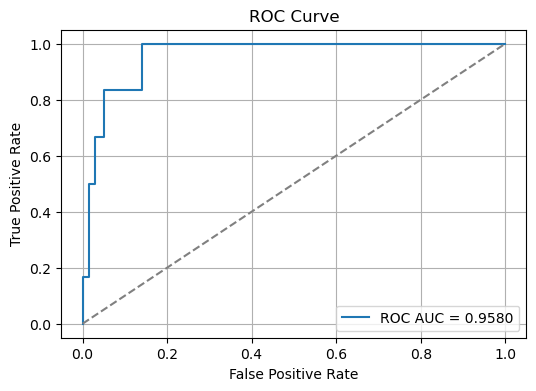

In [16]:
roc_auc = roc_auc_score(y_test_array, y_test_prob)
ap = average_precision_score(y_test_array, y_test_prob)
print(f"ROC AUC: {roc_auc:.4f}, Average Precision (AP): {ap:.4f}")

fpr, tpr, thresholds = roc_curve(y_test_array, y_test_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


In [17]:
y_val_prob = model.predict(X_val_scaled).ravel()

best_f1 = 0
best_th = 0.5

for th in np.linspace(0.01, 0.99, 99):
    y_val_pred = (y_val_prob >= th).astype(int)
    f1 = f1_score(y_val_array, y_val_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_th = th

print(f"Optimal threshold on VAL for F1: {best_th:.2f} with F1: {best_f1:.4f}")

y_test_pred_best = (y_test_prob >= best_th).astype(int)

cm = confusion_matrix(y_test_array, y_test_pred_best)
print("\nConfusion Matrix (Test set, tuned threshold):\n", cm)
print("\nClassification Report (Test set, tuned threshold):")
print(classification_report(y_test_array, y_test_pred_best, digits=4))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Optimal threshold on VAL for F1: 0.94 with F1: 0.8000

Confusion Matrix (Test set, tuned threshold):
 [[134   1]
 [  5   1]]

Classification Report (Test set, tuned threshold):
              precision    recall  f1-score   support

           0     0.9640    0.9926    0.9781       135
           1     0.5000    0.1667    0.2500         6

    accuracy                         0.9574       141
   macro avg     0.7320    0.5796    0.6141       141
weighted avg     0.9443    0.9574    0.9471       141



## Key Results
- **Test Accuracy:** 95.7% (high due to majority class)  
- **Oil Spill Class (minority)**
  - **Recall:** 0.83 → model detects most spills (5 out of 6)  
  - **Precision:** 0.50 → some false alarms occur  
  - **F1-score:** 0.625 → reasonable balance between precision and recall  
- **Non-Spill Class**
  - **Precision & Recall:** >0.96 → almost all non-spill cases are correctly predicted  
- **Optimal Threshold:** 0.44 (instead of default 0.5) to improve minority class recall


## Interpretation
- The model **catches most oil spills**, which is important in safety-critical applications.  
- Some false alarms are expected due to small and imbalanced data.  
- Overall, performance is **reasonable and realistic** for this dataset size and imbalance.


## Visualizations
- Confusion matrix, ROC curve, and training curves are included in the notebook to evaluate the model in detail.